# Requirement 5
## *Slightly non-stationary environments with multiple products*

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

### Environment

A slighly non-stationary environment, at a high level:
*   Rounds are partitioned in intervals
*   In each interval the distribution of products valuations is fixed
*   Each interval has a different distribution

In [97]:
class MultipleProductSlightyNonStationaryEnvironment:
  def __init__(self, T, N, distributions, min_interval, max_interval):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer

    self.min_interval = min_interval
    self.max_interval = max_interval
    self.interval_lengths = []
    self.interval_distributions = []
    self.valuations = []
    
    self.distributions = np.array(distributions)

  def reset_rounds(self):
    self.t = 0

  def get_interval_distributions(self):
    return self.interval_distributions

  def get_interval_lengths(self):
    return self.interval_lengths

  def get_intervals(self):
    # Define an array of interval lengths among the time horizon
    interval_lengths = []
    while sum(interval_lengths) < self.T:
      length = np.random.randint(self.min_interval, self.max_interval + 1)
      interval_lengths.append(length)

    return interval_lengths

  def set_intervals_distributions(self, interval_lengths):
    # Define an array of distributions to use in each interval
    interval_distributions = []

    for _ in range(len(interval_lengths)):
      dist_i = np.random.choice(len(self.distributions), size=self.N)
      interval_distributions.append(self.distributions[dist_i])

    return interval_distributions

  def init_environment(self):
    # Setup environment
    self.interval_lengths = self.get_intervals()
    self.interval_distributions = self.set_intervals_distributions(self.interval_lengths)

    for length, distributions in zip(self.interval_lengths, self.interval_distributions):
      for _ in range(length):
        self.valuations.append([distr.rvs() for distr in distributions])

    self.valuations = np.array(self.valuations)

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1

    return reward

### Agent - *Combinatorial-UCB with Sliding Window algorithm* **with inventory constraint** and *Multiplicative Pacing strategy for multiple products*

In [98]:
class CombinatorialUCB_SW:
    def __init__(self, T, B, P, N, W, scale=1):
        self.T = T
        self.P = P
        self.N = N
        self.W = W
        self.budget = B
        self.scale = scale

        self.N_pulls = np.zeros((N, P))

        self.f_cache = np.repeat(np.nan, repeats=W*N*P).reshape(W, N, P)
        self.c_cache = np.repeat(np.nan, repeats=W*N*P).reshape(W, N, P)

        self.pi_t = None

        self.t = 0

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            return np.array([None  for _ in range(self.N)])

        # Exploration: try each price vector at least once
        if self.t < self.P:
            self.pi_t = np.array([self.t for _ in range(self.N)])
        else:
            # Initialize f_ucb and c_ucb for each arm (matrix)
            f_ucbs_last_W = np.zeros((self.N, self.P), dtype=float)
            c_lcbs_last_W = np.zeros((self.N, self.P), dtype=float)
            avg_f_last_W = np.zeros((self.N, self.P))
            avg_c_last_W = np.zeros((self.N, self.P))

            N_pulls_last_W = np.array(self.W - np.isnan(self.f_cache).sum(axis=0))

            # For each unexplored arm, set a large value of f_ucb and 0 c_ucb
            #large_value = (1 + np.sqrt(2*np.log(self.T)/1))*10
            large_value = 1e10
            unexplored = (N_pulls_last_W == 0)
            f_ucbs_last_W[unexplored] = large_value
            c_lcbs_last_W[unexplored] = 0

            # Get the mask of the arms that have been pulled at least one time
            # and then set the f_ucb and c_ucb for these arms
            mask = N_pulls_last_W > 0
            avg_f_last_W[mask] = np.nanmean(self.f_cache, axis=0)[mask]     
            avg_c_last_W[mask] = np.nanmean(self.c_cache, axis=0)[mask]
            
            f_ucbs_last_W[mask] = avg_f_last_W[mask] + self.scale * np.sqrt(2 * np.log(self.W)/N_pulls_last_W[mask])
            c_lcbs_last_W[mask] = avg_c_last_W[mask] - self.scale * np.sqrt( 2 * np.log(self.W)/N_pulls_last_W[mask])
            c_lcbs_last_W[c_lcbs_last_W < 0] = 0

            # Optimal distribution over superarms
            gamma = self.compute_opt(f_ucbs_last_W.reshape(-1), c_lcbs_last_W.reshape(-1))

            # Set current prices
            sampled_indices = []
            for i in range(self.N):
                sampled_indices.append(np.random.choice(self.P, p=gamma[i]))
            self.pi_t = sampled_indices
        
        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # Total variables
        tot_vars = self.N * self.P

        # Per-round budget
        rho = (self.budget / (self.T - self.t + 1)) + 1.5

        # Variables
        c = -f_ucbs

        A_ub = [c_lcbs]
        b_ub = [rho]

        A_eq = []
        b_eq = []
        var_index = 0
        for i in range(self.N):
            eq_row = np.zeros(tot_vars)
            eq_row[var_index:var_index + self.P] = 1
            A_eq.append(eq_row)
            b_eq.append(1)
            var_index = var_index + self.P

        res = optimize.linprog(
            c, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=[(0, 1) for _ in range(tot_vars)]
        )

        if res.success:
            gamma = []
            solution = res.x
            var_index = 0
            for i in range(self.N): 
                gamma_i = solution[var_index : var_index + self.P]
                gamma_i = gamma_i / gamma_i.sum()  # Ensure normalization
                gamma_i = np.abs(gamma_i)
                gamma.append(gamma_i)
                var_index = var_index + self.P
            return gamma
        else:
            # Select UCB-maximizing price for each product
            return [np.eye(self.P)[np.argmax(f_ucbs[i])] for i in range(self.N)]

    def update(self, f_t, c_t):
        # Remove oldest observation
        self.f_cache = np.delete(self.f_cache, (0), axis=0)
        self.c_cache = np.delete(self.c_cache, (0), axis=0)

        f_new_samples = np.repeat(np.nan, repeats=self.N*self.P).reshape(self.N, self.P)
        c_new_samples = np.repeat(np.nan, repeats=self.N*self.P).reshape(self.N, self.P)

        # Update the number of pulls of each arm in played superarm
        for i in range(self.N):
            self.N_pulls[i][self.pi_t[i]] += 1

            f_new_samples[i][self.pi_t[i]] = f_t[i]            
            c_new_samples[i][self.pi_t[i]] = c_t[i]

        f_new_samples = np.expand_dims(f_new_samples, axis=0)
        c_new_samples = np.expand_dims(c_new_samples, axis=0)

        # Add new observation
        self.f_cache = np.vstack((self.f_cache, f_new_samples))
        self.c_cache = np.vstack((self.c_cache, c_new_samples))

        # Update budget
        self.budget = self.budget - np.sum(c_t)

        self.t += 1

In [99]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [100]:
class MultipleProductMultiplicativePacingAgent:
    def __init__(self, prices_set, budget, T, N, eta, learning_rate):
        self.prices_set = prices_set
        self.K = len(prices_set)
        self.learning_rate = learning_rate
        self.eta=eta
        self.budget = budget
        self.T=T
        self.N = N

        #a different exp3 agent for every product
        self.exp3_list = [EXP3Agent(self.K, self.learning_rate) for _ in range(self.N)]

        self.lmbd = 1                               # Shared lambda
        self.t = 0
        self.N_pulls = np.zeros((self.N, self.K)) # Count arm pulls per product
        self.price_index = 0
        self._lambdas = []

    def pull_arm(self):
        if self.budget < 1:
            self.p_t = np.array([1.1 for _ in range(self.N)])
            return self.p_t

        chosen_prices = []
        for i in range(self.N):
            self.price_index = self.exp3_list[i].pull_arm()
            chosen_prices.append(self.prices_set[self.price_index])

        return chosen_prices
    def update(self, f_t_list):
        rho = self.budget/ (self.T - self.t + 1) + 1.5
        c_t_list= [int(f_t > 0) for f_t in f_t_list]
        c_t_tot=sum(c_t_list)

        for i in range(self.N):
          f_t=f_t_list[i]
          c_t=c_t_list[i]
          L = f_t - self.lmbd*(c_t-rho)

          # linear rescale in the feasible interval
          L_up = 1 -(1/rho)*(-rho)
          L_low = 0 -(1/rho)*(1-rho)
          rescaled_L = (L - L_low)/(L_up-L_low)
          self.exp3_list[i].update(1 - rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(rho-c_t_tot),
                            a_min=0, a_max=1/rho)

        self._lambdas.append((self.lmbd, c_t))

        #update budget
        self.budget -= c_t_tot

    def get_budget(self):
      return self.budget

    def lambdas(self):
      return self._lambdas

### Clairvoyant - **with invetory constraint**

In [101]:
class MultipleProductSlighlyNonStationaryInventoryClairvoyant:
    def __init__(self, T, B, N, prices):
        self.T = T
        self.prices = prices
        self.budget = B
        self.N = N
        self.P = len(prices)

        self.interval_distributions = []
        self.interval_lengths = []

    def set_interval_lengths(self, interval_lengths):
        self.interval_lengths = interval_lengths

    def set_interval_distributions(self, interval_distributions):
        self.interval_distributions = interval_distributions
    
    def get_selling_probabilities(self, valuations_distr):
        obj = [1 - distr.cdf(self.prices) for distr in valuations_distr]
        return np.array(obj)   

    def run(self):
        # Number of variables
        tot_vars = self.N * self.P

        interval = 0
        expected_utilities = []
        for distr in self.interval_distributions:
            # Probability of selling
            selling_prob=self.get_selling_probabilities(distr)

            # Per-round budget
            rho = np.sum(np.min(selling_prob, axis=1)) + 1.5

            ## Linear programming
            c = -(selling_prob * self.prices).reshape(-1)

            A_ub = [selling_prob.reshape(-1)]
            b_ub = [rho]

            A_eq = []
            b_eq = []
            var_index = 0
            for _ in range(self.N):
                eq_row = np.zeros(tot_vars)
                eq_row[var_index:var_index + self.P] = 1
                A_eq.append(eq_row)
                b_eq.append(1)
                var_index = var_index + self.P

            res = optimize.linprog(
                c, 
                A_ub=A_ub, 
                b_ub=b_ub, 
                A_eq=A_eq, 
                b_eq=b_eq, 
                bounds=[(0, 1) for _ in range(tot_vars)]
            )

            for _ in range(self.interval_lengths[interval]):
                expected_utilities.append(-res.fun)
            interval = interval + 1
        return expected_utilities

### Execution

In [102]:
# Parameters
T = 10000
B = T * 75/100
N = 3
W = int(50 * np.sqrt(T))

min_interval = 800
max_interval = 1200

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)
P = len(prices)

distributions = [
    stats.uniform(loc=0, scale=1),
    stats.beta(a=4, b=2),
    stats.beta(a=2, b=4),
    stats.norm(loc=0.5, scale=1)
]

learning_rate = np.sqrt(np.log(P)/(P*T))  #learning rate EXP3
eta=1/np.sqrt(T)   #learing rate Multiplicative pacing

In [103]:
# Run clairvoyant
clairvoyant = MultipleProductSlighlyNonStationaryInventoryClairvoyant(T, B, N, prices)

n_trials = 5
cucb_regret_per_trial = []
pacing_regret_per_trial = []
cucb_budget_per_trial = []
pacing_budget_per_trial = []
cucb_prices_arr = []
pacing_prices_arr = []
for trial in range(n_trials):

  # Define environment and agent
  env = MultipleProductSlightyNonStationaryEnvironment(T, N, distributions, min_interval, max_interval)
  env.init_environment()

  clairvoyant.set_interval_distributions(env.get_interval_distributions())
  clairvoyant.set_interval_lengths(env.get_interval_lengths())
  expected_clairvoyant_utilities = clairvoyant.run()[:T]


  # Combinatorial-UCB
  combinatorial_ucb_sw = CombinatorialUCB_SW(T, B, P, N, W, scale=max_price)
  cucb_agent_rewards = []
  budget = []
  for t in range(T):
    # This returns the price index
    pi_t = combinatorial_ucb_sw.pull_arm()

    # Check if budget is depleted -> reward always 0
    if np.any(pi_t == None):
      r_t = np.zeros(N)
    else:
      # Get the actual price
      p_t = prices[pi_t]

      # Get reward
      r_t = env.round(p_t)

      cucb_prices_arr.append(p_t)

      # Update agent state
      combinatorial_ucb_sw.update(r_t, r_t > 0.)

    cucb_agent_rewards.append(np.sum(r_t))
    budget.append(combinatorial_ucb_sw.budget)

  cucb_agent_rewards = np.array(cucb_agent_rewards)
  cucb_cumulative_regret = np.cumsum(expected_clairvoyant_utilities - cucb_agent_rewards)
  cucb_regret_per_trial.append(cucb_cumulative_regret)
  cucb_budget_per_trial.append(budget)

  env.reset_rounds()

  # Primal dual method
  multiplicative_pacing_agent = MultipleProductMultiplicativePacingAgent(prices, B, T, N, eta, learning_rate)
  pacing_agent_rewards = []
  count = 0
  budget = []
  for t in range(T):
    if(count>=B):
      r_t = 0
      pacing_agent_rewards.append(np.sum(r_t))
    else:
      # Get the actual price
      p_t = multiplicative_pacing_agent.pull_arm()
      # Get reward
      r_t = env.round(p_t)

      pacing_prices_arr.append(p_t)

      # Update agent state
      multiplicative_pacing_agent.update(r_t)
      count += np.sum(r_t > 0)
      
      pacing_agent_rewards.append(np.sum(r_t))
    budget.append(multiplicative_pacing_agent.budget)

  pacing_agent_rewards = np.array(pacing_agent_rewards)
  pacing_cumulative_regret = np.cumsum(expected_clairvoyant_utilities - pacing_agent_rewards)
  pacing_regret_per_trial.append(pacing_cumulative_regret)
  pacing_budget_per_trial.append(budget)

cucb_regret_per_trial = np.array(cucb_regret_per_trial)
cucb_average_regret = cucb_regret_per_trial.mean(axis=0) # mean
cucb_regret_sd = cucb_regret_per_trial.std(axis=0) # standard deviation

pacing_regret_per_trial = np.array(pacing_regret_per_trial)
pacing_average_regret = pacing_regret_per_trial.mean(axis=0) # mean
pacing_regret_sd = pacing_regret_per_trial.std(axis=0) # standard deviation

cucb_budget_per_trial = np.array(cucb_budget_per_trial)
cucb_average_budget = cucb_budget_per_trial.mean(axis=0) # mean
cucb_budget_sd = cucb_budget_per_trial.std(axis=0) # standard deviation

pacing_budget_per_trial = np.array(pacing_budget_per_trial)
pacing_average_budget = pacing_budget_per_trial.mean(axis=0) # mean
pacing_budget_sd = pacing_budget_per_trial.std(axis=0) # standard deviation

### Results

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_87959/2220030280.py:7: SyntaxWarning: invalid escape sequence '\s'
  axs[0].plot(t, theoretical_curve, label="$\sqrt{NPTΦlog(T)}$", linestyle="--", color="red")


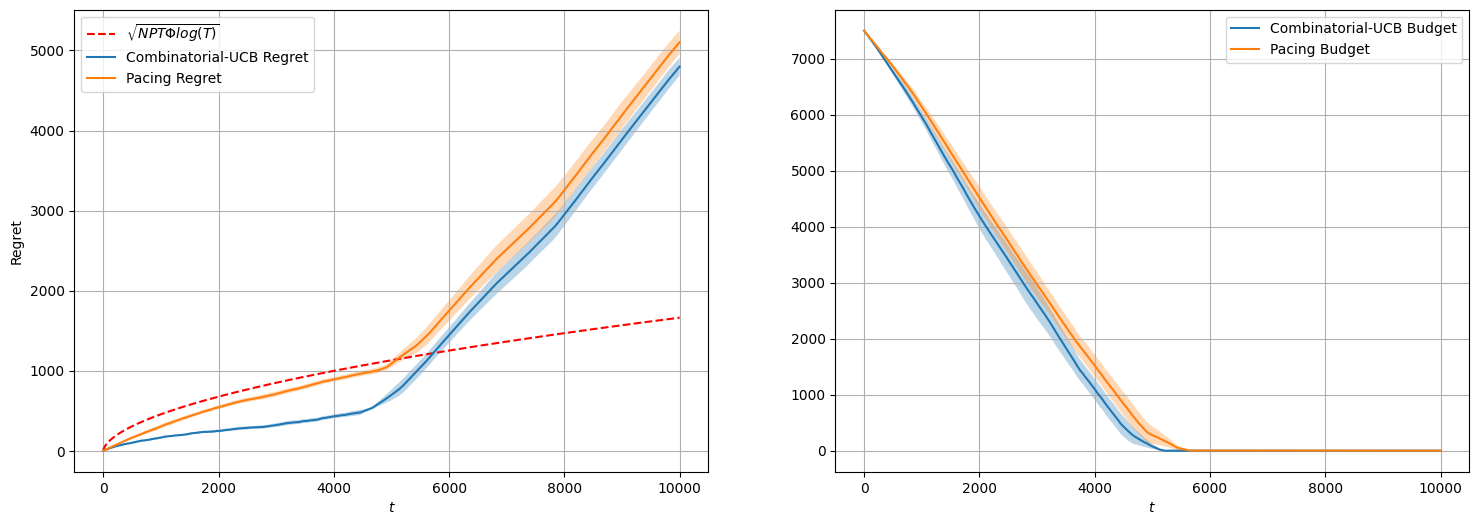

In [107]:
t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = (N*P*T/W*t*np.log(t))**(1/2)

fig, axs = plt.subplots(1, 2, figsize = (18, 6))

# Regret plot
axs[0].plot(t, theoretical_curve, label="$\sqrt{NPTΦlog(T)}$", linestyle="--", color="red")

axs[0].plot(np.arange(T), cucb_average_regret, label=f'Combinatorial-UCB Regret')
axs[0].fill_between(
    np.arange(T),
    cucb_average_regret-cucb_regret_sd/np.sqrt(n_trials),
    cucb_average_regret+cucb_regret_sd/np.sqrt(n_trials),
    alpha=0.3
)

axs[0].plot(np.arange(T), pacing_average_regret, label=f'Pacing Regret')
axs[0].fill_between(
    np.arange(T),
    pacing_average_regret-pacing_regret_sd/np.sqrt(n_trials),
    pacing_average_regret+pacing_regret_sd/np.sqrt(n_trials),
    alpha=0.3
)

axs[0].set_xlabel("$t$")
axs[0].set_ylabel("Regret")
axs[0].legend()
axs[0].grid(True)

# Budget plot
axs[1].plot(np.arange(T), cucb_average_budget, label=f'Combinatorial-UCB Budget')
axs[1].fill_between(
    np.arange(T),
    cucb_average_budget-cucb_budget_sd/np.sqrt(n_trials),
    cucb_average_budget+cucb_budget_sd/np.sqrt(n_trials),
    alpha=0.3
)

axs[1].plot(np.arange(T), pacing_average_budget, label=f'Pacing Budget')
axs[1].fill_between(
    np.arange(T),
    pacing_average_budget-pacing_budget_sd/np.sqrt(n_trials),
    pacing_average_budget+pacing_budget_sd/np.sqrt(n_trials),
    alpha=0.3
)

axs[1].set_xlabel("$t$")
axs[1].legend()
axs[1].grid(True)

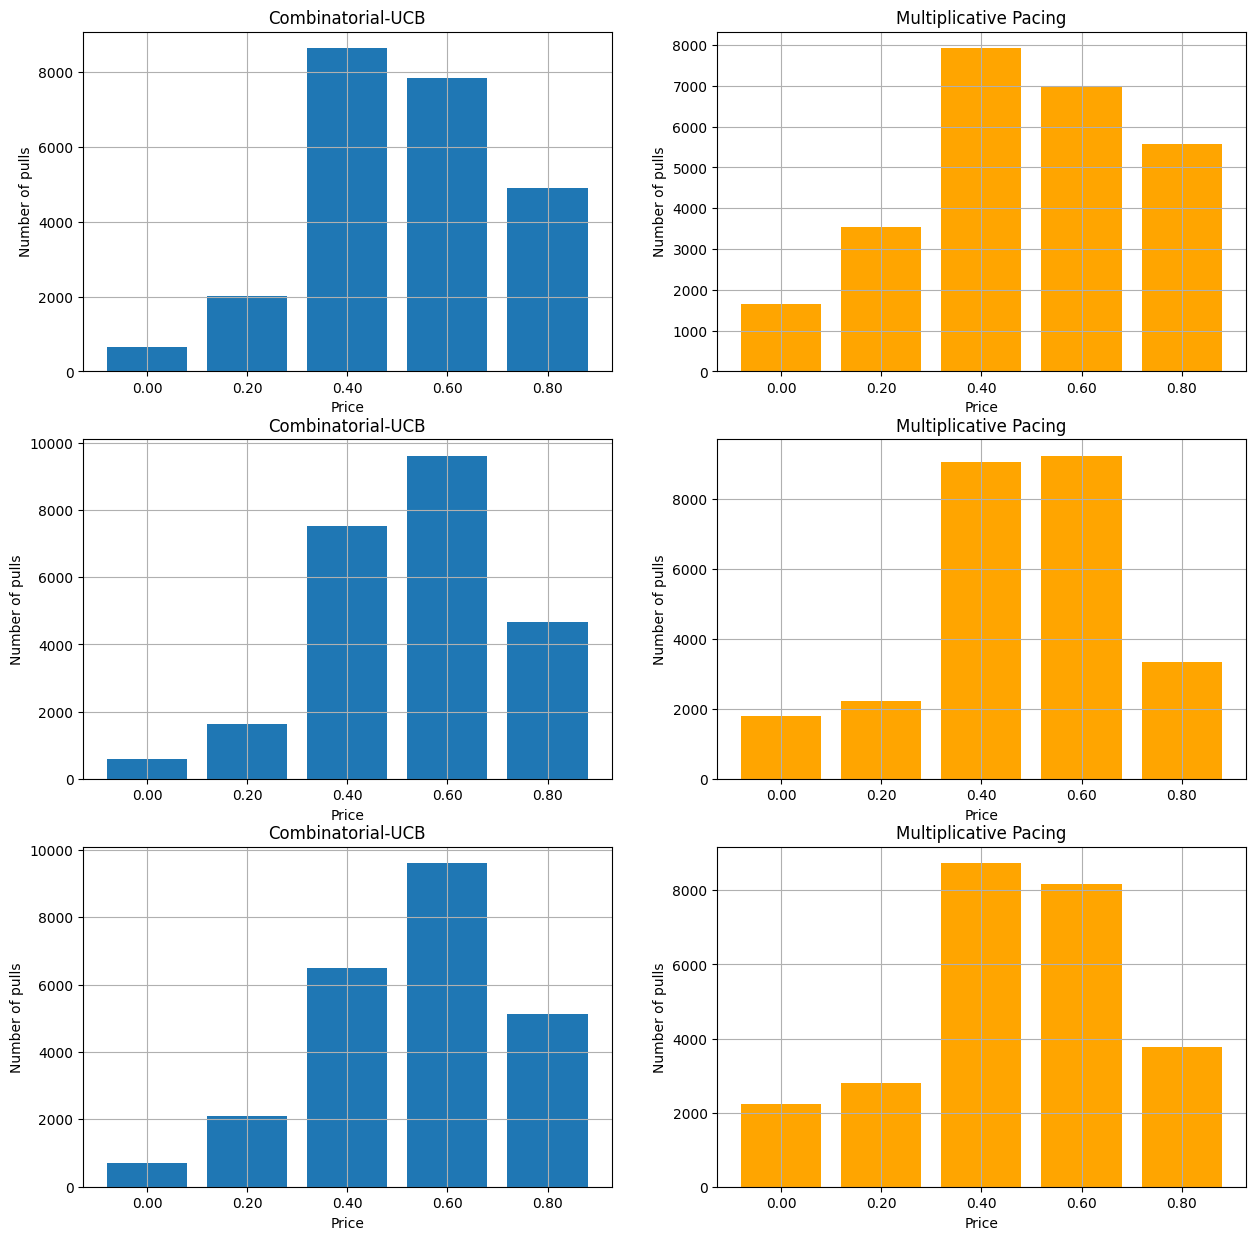

In [105]:
from collections import Counter

fig, axs = plt.subplots(N, 2, figsize=(15, 15))

cucb_prices_arr = np.array(cucb_prices_arr)
pacing_prices_arr = np.array(pacing_prices_arr)
for i in range(N):
    price_counts = Counter(cucb_prices_arr[:, i])
    sorted_prices = sorted(price_counts)
    counts = [price_counts[p] for p in sorted_prices]

    axs[i, 0].bar([f"{p:.2f}" for p in sorted_prices], counts)
    axs[i, 0].set_xlabel("Price")
    axs[i, 0].set_ylabel("Number of pulls")
    axs[i, 0].set_title("Combinatorial-UCB")
    axs[i, 0].grid(True)

    price_counts = Counter(pacing_prices_arr[:, i])
    sorted_prices = sorted(price_counts)
    counts = [price_counts[p] for p in sorted_prices]

    axs[i, 1].bar([f"{p:.2f}" for p in sorted_prices], counts, color="orange")
    axs[i, 1].set_xlabel("Price")
    axs[i, 1].set_ylabel("Number of pulls")
    axs[i, 1].set_title("Multiplicative Pacing")
    axs[i, 1].grid(True)